In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pickle 
from numpy.linalg import eigvals, eig

def f_deltar(deltar, delta, g):
    return delta * (1 - 2 * np.sum((-g / (np.sqrt(N) * (deltar + w))) ** 2))

def f_f(deltar, g):
    return -g / (np.sqrt(N) * (deltar + w))

def f_analisis(deltas, gs):
    deltar = 0

    analisis = {}

    for delta in deltas:
        delta = round(delta, 2)
        analisis[delta] = {}

        for g in gs: 
            g = round(g, 4)

            while True:
                change = abs(deltar - f_deltar(deltar, delta, g))
                deltar = f_deltar(deltar, delta, g)

                if change < 1e-3: #cuando la mejora es ya muy pequeña cierro el bucle
                    break 

            analisis[delta][g] = deltar #guardo los valores de deltar para poder usarlos más tarde

    return analisis

def eff_hamiltonian(deltar, g):
    h1 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    h1[0, 0] = deltar / 2
    
    h2 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        h2[1 + k, 1 + k] = w[k] - deltar / 2
        
    h3 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    f = f_f(deltar, g)
    for k in range(N):
        h3[k + 1, 0] = -2 * deltar * f[k]
        h3[0, k + 1] = -2 * deltar * f[k]
        
    h4 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        for p in range(N):
            h4[p + 1, k + 1] = 2 * deltar * f[k] * f[p]
    
    return h1 + h2 + h3 + h4

def rwa_hamiltonian(delta, g):
    h1 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    h1[0, 0] = delta / 2
    
    h2 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        h2[1 + k, 1 + k] = w[k] - delta / 2
        
    h3 = np.zeros(shape = (N + 1, N + 1), dtype = np.complex_)
    for k in range(N):
        h3[k + 1, 0] = g / np.sqrt(N)
        h3[0, k + 1] = g / np.sqrt(N)
    
    return h1 + h2 + h3

def sorted_eigsystem(H):
    vals, vects = eig(H)
    idx = np.argsort(vals)
    vals = vals[idx]
    vects = vects[:,idx]
    
    return Eigensystem(vals, vects)

class Eigensystem:
    def __init__(self, vals, vects):
        self.vals = vals
        self.vects = vects
        self.size = len(vals)

def f_eigenanalisis(analisis):
    eigenanalisis_eff = {}
    eigenanalisis_rwa = {}
    
    for delta in analisis.keys():
        eigenanalisis_eff[delta] = {}
        eigenanalisis_rwa[delta] = {}
        
        for g in analisis[delta].keys():
            H_eff = eff_hamiltonian(analisis[delta][g], g)
            H_rwa = rwa_hamiltonian(delta, g)

            eig_eff = sorted_eigsystem(H_eff)
            eig_rwa = sorted_eigsystem(H_rwa)
            
            eigenanalisis_eff[delta][g] = eig_eff
            eigenanalisis_rwa[delta][g] = eig_rwa
            
    return eigenanalisis_eff, eigenanalisis_rwa

import scipy.sparse as sparse
import scipy.sparse.linalg
import numpy as np

class PolaronDecay:
    def __init__(self, g, Delta=1):
        self.g = g
        self.Delta = Delta
        self.DeltaR = f_analisis([self.Delta], [self.g])[self.Delta][self.g]
        self.fk = f_f(self.DeltaR, self.g)
        self.L = L = self.fk.size
        self.i2 = i2 = sparse.eye(2)
        self.iL = iL = sparse.eye(L+1)
        
        # Qubit operators
        sx = sparse.coo_matrix([[0,1],[1,0]])
        sz = sparse.coo_matrix([[-1,0],[0,1]])
        Hqubit = self.DeltaR * sz / 2.0
        self.sx = sparse.kron(sx, self.iL)
        self.sz = sparse.kron(sz, self.iL)
        
        # Photon operators
        fA = np.zeros((L+1,L+1))
        fA[0,1:] = self.fk
        fA = sparse.coo_matrix(fA)
        Hphotons = sparse.diags([0]+[w[i] for i in range(0,L)],
                                offsets=0, shape=(L+1,L+1))
        
        Vlocal = -2.0 * self.DeltaR * sparse.kron(sz, fA.T @ fA)
        self.H = (sparse.kron(Hqubit,iL) + Vlocal +
                  sparse.kron(i2, Hphotons) +
                  sparse.kron(2.0 * self.DeltaR * sx, fA + fA.T))

        # Value of Sz once we undo the polaron transformation
        self.szlab= (self.DeltaR/Delta * self.sz  +
                     2* self.DeltaR/Delta * sparse.kron(sx @ sz, fA.T- fA) -
                     4 * self.DeltaR/Delta * sparse.kron(sz, fA.T @ fA))

        #print(self.DeltaR)
        
        # Empty state
        self.psi0 = np.zeros((2*(L+1),))
        self.psi0[0] = 1.0
        
        
    '''
    def Hamiltonian(self):
            return self.H
    '''
    
    def evolve(self, t, nsteps=100):
        if not isinstance(t,np.ndarray):
            t = np.linspace(0, t, nsteps)
        psi = self.sx @ self.psi0
        dt = t[1]-t[0]
        output = np.zeros((t.size,2),dtype=np.float64)
        for i,_ in enumerate(t):
            if i:
                #psi = lanczos.expm(self.H, psi, dt=dt, tol=1e-12)
                psi = scipy.sparse.linalg.expm_multiply((-1j*dt)*self.H, psi)
            output[i,:] = [np.vdot(psi, self.sz @ psi).real,
                           np.vdot(psi, self.szlab @ psi).real]
        return  output, t, psi
    
    def spectrum(self, psi):
        return np.abs(psi[1:(self.L+1)]**2)+np.abs(psi[self.L+2:]**2)

In [2]:
w0 = 1.0
J = 0.4
N = 100
deltas = np.arange(0.1, 1.9, 0.1)
gs = np.arange(0.0, 0.30, 0.01)
ks = np.arange(N)
w = w0 - 2 * J * np.cos(2 * np.pi / N * ks)

analisis = f_analisis(deltas, gs)

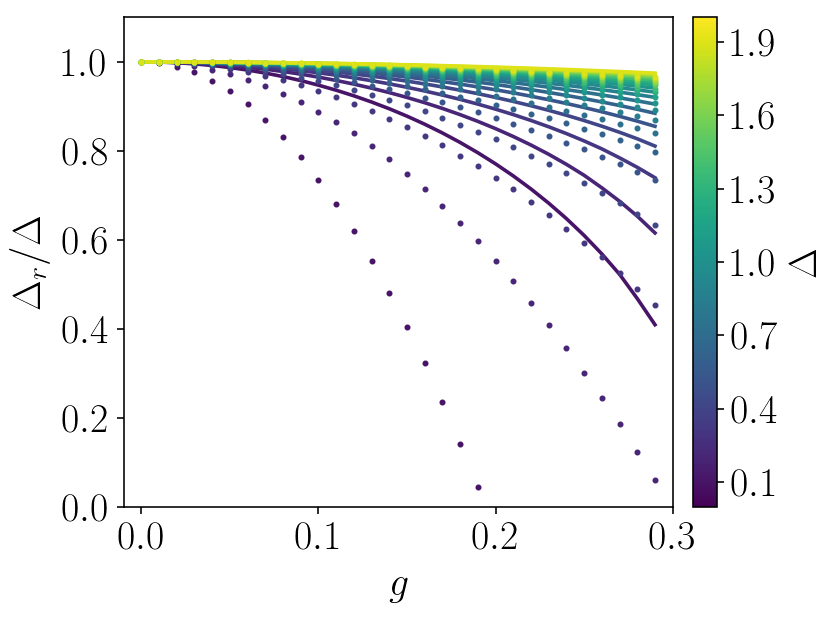

In [11]:
plt.rcParams['figure.figsize'] = 6, 4.5
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 20
sns.set_palette(sns.color_palette("viridis", len(analisis)))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def new_deltar(delta, g):
    return delta * (1 - 2 * np.sum(g ** 2 / (N * delta * (w + delta))))

#for label (a)/ (b)
fig, ax = plt.subplots()
"""plt.text(0.06, 0.08, r'\textbf{(a)}',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, fontsize = 18)

"""
for delta in analisis.keys():
    plt.plot([g for g in analisis[delta].keys()], [deltar / delta for deltar in analisis[delta].values()])
    
for delta in analisis.keys():
    plt.plot([g for g in analisis[delta].keys()], [new_deltar(delta, g) / delta for g in analisis[delta].keys()], marker = 'o', lw = 0, ms = 2)
    
plt.ylabel(r'$\Delta_r/\Delta$')
plt.xlabel(r'$g$')
#plt.xticks([0.00, 0.25, 0.50, 0.75, 1.00, 1.25])
plt.xlim(-0.01, 0.3)
plt.ylim(-0.0, 1.1)


#for side color bar
cmap = ListedColormap(sns.color_palette('viridis', 10 * len(deltas)))
norm = mpl.colors.Normalize(vmin = 0,vmax = 2)
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])
plt.colorbar(sm, label = r'$\Delta$', ticks = (np.arange(0.1, 1.91, 0.3)), pad = 0.03)


plt.savefig('figures/1q_delta_renorm.pdf', bbox_inches = 'tight')
plt.show()

In [24]:
analisis = f_analisis(deltas, gs)

f = open('analisis/analisis.pk', 'wb')
#pickle.dump(analisis, f)
f.close()

In [25]:
eigen_eff, eigen_rwa = f_eigenanalisis(analisis)

f = open('analisis/eigenanalisis.pk', 'wb')
pickle.dump((eigen_eff, eigen_rwa), f)
f.close()